# Declarations

In [9]:
def import_or_install(package):
#     source : 
#     stackoverflow.com/questions/4527554/check-if-module-exists-if-not-install-it
    """
    Input : string package
    Output : install package if it does not exist
    """
    try:
        __import__(package)
    except ImportError:
        pip.main(['install',package])

In [31]:
import pandas as pd
import numpy as np
import json
import pip
import re
from urllib.request import urlopen
import_or_install('wikidata')
import requests
from wikidata.client import Client
from scipy import stats
import powerlaw
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle
from fa2 import ForceAtlas2
import operator


## Functions declarations

In [11]:
def load_all_to_df(*datasets):
    """
    Input : strings of CSVs titles
    Output: pandas dataframe containg all records in all CSVs
    """
    df_list = [pd.read_csv(dataset) for dataset in datasets]
    return pd.concat(df_list, ignore_index=True)

In [12]:
def get_wikipedia_url(wikidata):
    """
    Input : string wikidata ID
    Output: wikipedia page url
    """
    client = Client()
    entity = client.get(wikidata, load=True)
    return entity.data['sitelinks']['enwiki']['url']

In [13]:
def get_wikipedia_title(url):
    """
    Input : string wikipedia url
    Output : string wikipedia title
    """
    pattern = r'/'
    words = re.sub(pattern,' ',url).split(' ')
    return words[-1]

In [14]:
def get_json_wikipedia(url):
    baseurl = 'https://en.wikipedia.org/w/api.php?'
    action = 'action=query'
    content = '&prop=revisions&rvprop=content'
    dataformat = '&format=json'
    title = '&titles=' + get_wikipedia_title(url)
    query = "%s%s%s%s%s" % (baseurl,action,content,dataformat,title)
    
    wikiresponse = urlopen(query)
    wikisource = wikiresponse.read()
    
    return json.loads(wikisource)

In [15]:
def get_content_wikipedia(member: str, 
    action = 'query',
    name = None,
    prop = 'revisions',
    export = False,
    df = None
    ) -> list:
    """"
    A function that takes in a character title on wikipedia and returns the
    a list with dictionaries containing the title of the characters 
    whose links are referenced in the wikipedia page

    Attributes
    ----------
    character : string
        Character wikilink
    action : string
        The action that you need for the wikipage, default is query.
    name : string
        The name of the character. Will aslo be used as the filename for the pickle file.
    prop : string
        The type of content required from the wikipage. If links is selected then you will get all links from the wikipage.
    Export : bool 
        If set to True the function will export the characters into pickle files to a directory (already set).
    df : pandas dataframe
        If given, will be used to filter all links into a list of characters found in that dataframe.

    Returns
    -------
    wikitext : string
        The text found on a character's wikipedia page.
    """
    url = "https://en.wikipedia.org/w/api.php"
    # prop = 'revisions' <- Has a more html look, can be useful for finding links
    # format = 'json'
    # prop = 'extracts' <- looks good but has not html 
    # prop = 'links' <- returns only the links found on the wikipage
    # pllimit=max
    Params = {
        'action':action,
        'format':'json',
        'prop':prop,
        'titles':get_wikipedia_title(member),
        'rvprop':'content'
    }
    try:
        if prop == 'links':
            Params['pllimit'] = 'max'
            response = requests.get(url=url, params=Params).json()
            page = next(iter(response['query']['pages'].values()))
            title = [name['title'] for name in page['links']]
            if export == True:
                filepath = f'Characters_links/{name}.pkl'.format(name=name)
                pickle.dump(title, open( filepath, "wb" ) )
                print(f'{name}.pkl has been saved succesfully')
                return None
            return title
            # url = 'https://en.wikipedia.org/w/api.php?action={action}&prop={prop}&rvprop=content&format={format}&titles={title}&rvslots=main&explaintext=True'.format(action=action, format=format, title=character, prop=prop)
        elif prop == 'extracts':
            Params['explaintext'] = True
            response = requests.get(url=url, params=Params).json()
            print(member)
            # page = next(iter(response['query']['pages'].values()))
            page = response['query']['pages']#.values()
            key = list(page.keys())[0]
            page = page[key]['extract']
            if export == True:
                if name != None:
                    character = character.replace('|',' ')
                    filepath = f'Characters_texts/{name}.pkl'.format(name=name)
                    pickle.dump(page, open( filepath, "wb" ) )
                    print(f'{name}.pkl has been saved succesfully')
                else:
                    filepath = f'Characters_texts/{character}.pkl'.format(character=character)
                    pickle.dump(page, open( filepath, "wb" ) )
                    print(f'{character}.pkl has been saved succesfully')
                return None
            return page
    except KeyError:
        print('Member not found in wikipedia')

In [16]:
def connection_count(df = None):
    """
    Input : pandas dataframe
    Output : pandas dataframe with a new column containing the number of connections
    """
    df['connections'] = 0
    for wikiId in df.wikidata:
        url = get_wikipedia_url(wikiId)
        member = get_wikipedia_title(url)
        links = get_content_wikipedia(member, prop='links')
        try:
            for i in df.name:
                if i in links:
                    df.loc[df.wikidata == wikiId, 'connections'] += 1
        except TypeError:
            df.loc[df.name == i, 'connections'] = 0
    return df

In [17]:
def connection_links(wikiId) -> list:
    """
    Output : list of all links found in the wikipedia pages of all members
    """
    url = get_wikipedia_url(wikiId)
    member = get_wikipedia_title(url)
    links = get_content_wikipedia(member, prop='links')
    return links

# Load data for all members: senate and congress

In [18]:
df_members = load_all_to_df('term-116_congress.csv','term-116_senate.csv')
member_wikiID = df_members.loc[1,'wikidata']
url = get_wikipedia_url(member_wikiID)
# get_json_wikipedia(url)

## Conection count

We are now going to try to see if we can get the number of connections for a member. This will then be added as a new column to our dataframe. First of all we will see in the example below how the calculation is done.

In [19]:
member = get_wikipedia_title(url) # Name of the politician
cont = get_content_wikipedia(member, prop='extracts') # Full wikipedia article in extract format for better readability
cont_link = get_content_wikipedia(member, prop='links') # Array of links found in politician's wikipedia page.

Drew_Ferguson_(politician)


In [20]:
found = 0
for i in df_members.name: #
    if i in cont_link:
        # print(df_members.loc[df_members.wikidata == member_wikiID].name) # uncomment to see which politician we are getting the connections from
        found += 1
print(found)

192


Now that we know exactly how the code is working we will utilize the `connection_count` function to obtain a new dataframe with the column we are looking for. It is important to note that the function will return a 0 alongside a message if the politician is not found in wikipedia.

In [21]:
df_connections = connection_count(df_members)

Member not found in wikipedia
Member not found in wikipedia
Member not found in wikipedia
Member not found in wikipedia
Member not found in wikipedia
Member not found in wikipedia
Member not found in wikipedia
Member not found in wikipedia
Member not found in wikipedia
Member not found in wikipedia
Member not found in wikipedia
Member not found in wikipedia


In [22]:
df_connections.head()

,id,name,sort_name,email,twitter,facebook,group,group_id,area_id,area,chamber,term,start_date,end_date,image,gender,wikidata,wikidata_group,wikidata_area,connections
0,eaf0104e-b8ae-4336-a353-ca5228fe2752,A. Donald McEachin,"McEachin, A.",NaN,RepMcEachin,RepMcEachin,Democrat,democrat,VA-4,Virginia's 4th congressional district,House of Representatives,116,NaN,NaN,https://theunitedstates.io/images/congress/ori...,male,Q4647699,Q29552,Q7934058,0
1,c5441370-42c5-4d83-b73e-6130cc4910cc,A. Drew Ferguson IV,"Ferguson, A.",NaN,RepDrewFerguson,RepDrewFerguson,Republican,republican,GA-3,Georgia's 3rd congressional district,House of Representatives,116,NaN,NaN,https://theunitedstates.io/images/congress/ori...,male,Q26157659,Q29468,Q5547263,192
2,05165473-b19d-484d-8de3-e6ed420cc299,Abby Finkenauer,"Finkenauer, Abby",NaN,NaN,NaN,Democrat,democrat,IA-1,Iowa's 1st congressional district,House of Representatives,116,NaN,NaN,https://theunitedstates.io/images/congress/ori...,female,Q24435337,Q29552,Q13858962,4
3,6133038f-b893-45d2-aa09-a7feb433edf7,Abigail Davis Spanberger,"Spanberger, Abigail",NaN,NaN,NaN,Democrat,democrat,VA-7,Virginia's 7th congressional district,House of Representatives,116,NaN,NaN,https://theunitedstates.io/images/congress/ori...,female,Q55603085,Q29552,Q7934064,160
4,e0b61cab-a183-4a44-bb0a-81f25fda8de3,Adam B. Schiff,"Schiff, Adam",NaN,RepAdamSchiff,RepAdamSchiff,Democrat,democrat,CA-28,California's 28th congressional district,House of Representatives,116,NaN,NaN,https://theunitedstates.io/images/congress/ori...,male,Q350843,Q29552,Q5020000,130


We can now see the new column of data in our dataframe. It is now time wee see how it's distributed.

<AxesSubplot:xlabel='connections', ylabel='Count'>

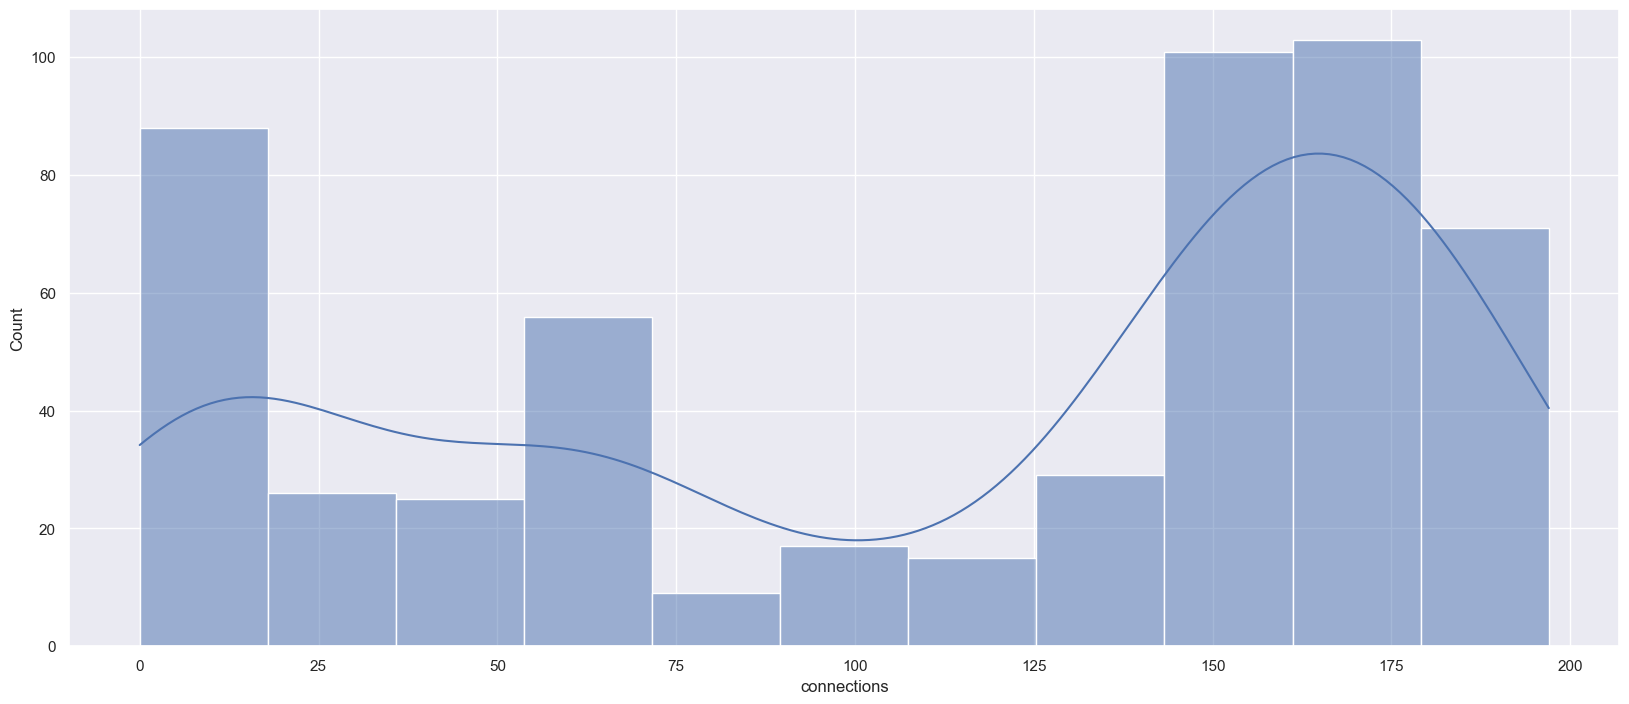

In [23]:
# fig, ax = plt.subplots(1, 2, figsize=(22,8))

sns.set(rc={'figure.figsize':(20,8.27)})
sns.histplot(data=df_connections, x="connections", kde=True)
# plt.xticks(rotation=90)

<AxesSubplot:xlabel='connections', ylabel='name'>

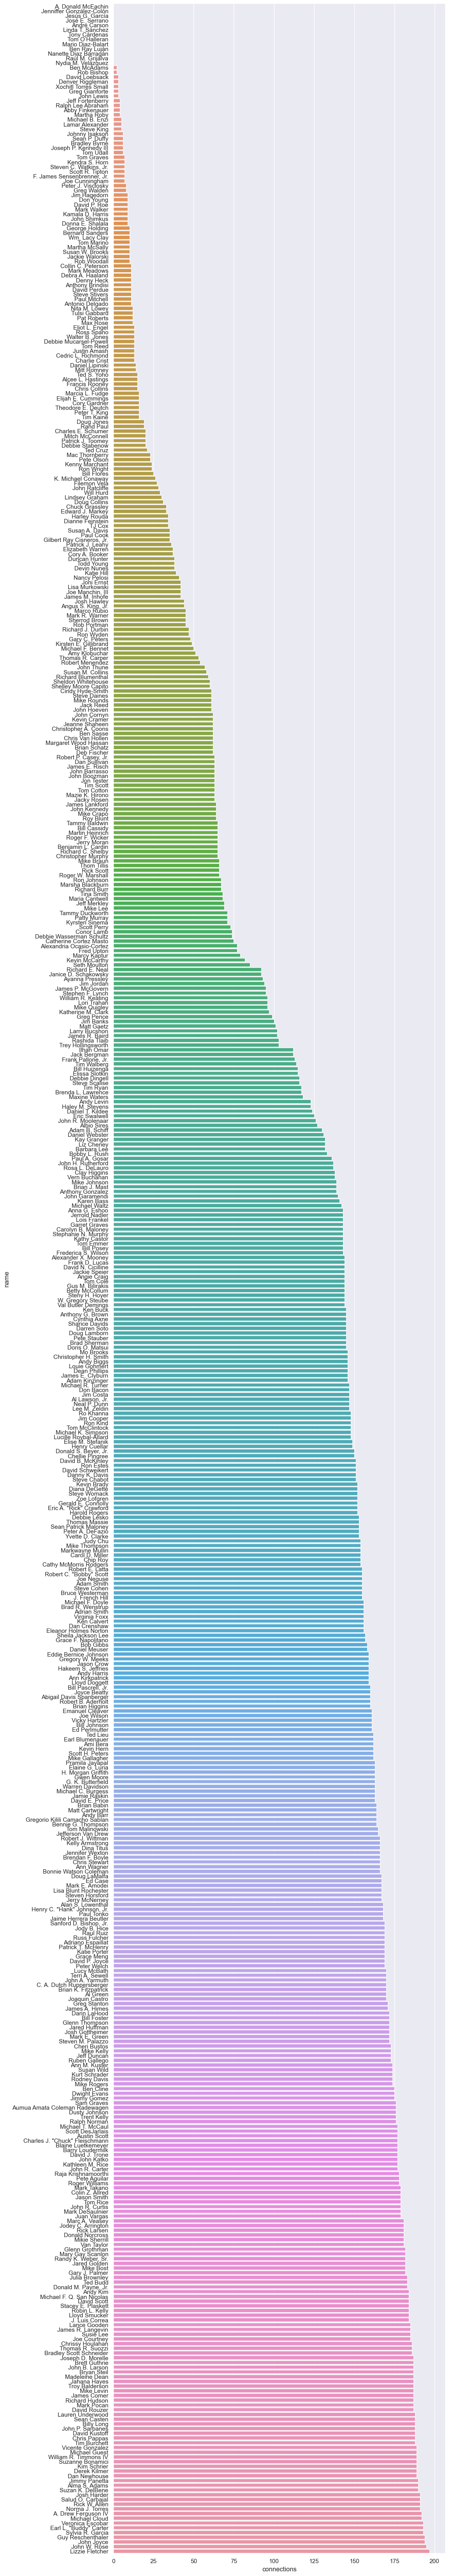

In [24]:
# WARNING big visual below
sns.set(rc={'figure.figsize':(11,85)})
sns.barplot(data=df_connections, y = 'name', x = 'connections', order=df_connections.sort_values('connections').name)
# plt.xticks(rotation=90)

## Graph Creation

In [25]:
df_connections.head()

,id,name,sort_name,email,twitter,facebook,group,group_id,area_id,area,chamber,term,start_date,end_date,image,gender,wikidata,wikidata_group,wikidata_area,connections
0,eaf0104e-b8ae-4336-a353-ca5228fe2752,A. Donald McEachin,"McEachin, A.",NaN,RepMcEachin,RepMcEachin,Democrat,democrat,VA-4,Virginia's 4th congressional district,House of Representatives,116,NaN,NaN,https://theunitedstates.io/images/congress/ori...,male,Q4647699,Q29552,Q7934058,0
1,c5441370-42c5-4d83-b73e-6130cc4910cc,A. Drew Ferguson IV,"Ferguson, A.",NaN,RepDrewFerguson,RepDrewFerguson,Republican,republican,GA-3,Georgia's 3rd congressional district,House of Representatives,116,NaN,NaN,https://theunitedstates.io/images/congress/ori...,male,Q26157659,Q29468,Q5547263,192
2,05165473-b19d-484d-8de3-e6ed420cc299,Abby Finkenauer,"Finkenauer, Abby",NaN,NaN,NaN,Democrat,democrat,IA-1,Iowa's 1st congressional district,House of Representatives,116,NaN,NaN,https://theunitedstates.io/images/congress/ori...,female,Q24435337,Q29552,Q13858962,4
3,6133038f-b893-45d2-aa09-a7feb433edf7,Abigail Davis Spanberger,"Spanberger, Abigail",NaN,NaN,NaN,Democrat,democrat,VA-7,Virginia's 7th congressional district,House of Representatives,116,NaN,NaN,https://theunitedstates.io/images/congress/ori...,female,Q55603085,Q29552,Q7934064,160
4,e0b61cab-a183-4a44-bb0a-81f25fda8de3,Adam B. Schiff,"Schiff, Adam",NaN,RepAdamSchiff,RepAdamSchiff,Democrat,democrat,CA-28,California's 28th congressional district,House of Representatives,116,NaN,NaN,https://theunitedstates.io/images/congress/ori...,male,Q350843,Q29552,Q5020000,130


In [26]:
# Thank you Magnus
def graphCreator(DG, df):
    # Creating directed network
    for politician in df.name:
        party = df.loc[df.name == politician, 'group'].values[0]
        # print(f'party a {party}')
        # print(party)
        DG.add_nodes_from([(politician, {'Party' : party})])
        id = df.loc[df.name == politician, 'wikidata'].values[0]
        # print(id[1])
        links = connection_links(id)
        try:
            for name in df.name:
                if name in links:
                    party = df.loc[df.name == name, 'group'].values[0]
                    # print(f'party b {party}')
                    DG.add_nodes_from([(name, {'Party' : party})])
                    DG.add_edge(politician, name)
        except TypeError:
            pass

In [27]:
DG = nx.DiGraph()
graphCreator(DG, df_connections)

Member not found in wikipedia
Member not found in wikipedia
Member not found in wikipedia
Member not found in wikipedia
Member not found in wikipedia
Member not found in wikipedia
Member not found in wikipedia
Member not found in wikipedia
Member not found in wikipedia
Member not found in wikipedia
Member not found in wikipedia
Member not found in wikipedia


### Graph Analisis

In [28]:
# Number of links between Marvel and DC
count = 0
for a,b in DG.edges():
    # print(DG.nodes[a]['Party'])
    if DG.nodes[a]['Party'] != DG.nodes[b]['Party']:
        count = count+1
print(f'Number of links between Democrats and Republicans: {count}')

Number of links between Democrats and Republicans: 29332


In [29]:
in_degrees = sorted((d for n, d in DG.in_degree()), reverse=False)
out_degrees = sorted((d for n, d in DG.out_degree()), reverse=True)

print(f'in-degree stats: \nMean: {np.mean(in_degrees)} \nMedian: {np.median(in_degrees)}   \nMode: {stats.mode(in_degrees)} \nMinimum:  {np.min(in_degrees)} \nMaximum: {np.max(in_degrees)} \n')

print(f'out-degree stats: \nMean: {np.mean(out_degrees)} \nMedian: {np.median(out_degrees)}   \nMode: {stats.mode(out_degrees)} \nMinimum:  {np.min(out_degrees)} \nMaximum: {np.max(out_degrees)}')

in-degree stats: 
Mean: 112.00740740740741 
Median: 17.5   
Mode: ModeResult(mode=array([0]), count=array([226])) 
Minimum:  0 
Maximum: 364 

out-degree stats: 
Mean: 112.00740740740741 
Median: 144.0   
Mode: ModeResult(mode=array([0]), count=array([12])) 
Minimum:  0 
Maximum: 197


C:\Users\guzma\AppData\Local\Temp\ipykernel_24880\3606209272.py:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  print(f'in-degree stats: \nMean: {np.mean(in_degrees)} \nMedian: {np.median(in_degrees)}   \nMode: {stats.mode(in_degrees)} \nMinimum:  {np.min(in_degrees)} \nMaximum: {np.max(in_degrees)} \n')
C:\Users\guzma\AppData\Local\Temp\ipykernel_24880\3606209272.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` ov

Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
The slope of the in degree distribution when fitted with a power law: 90.65806413394643


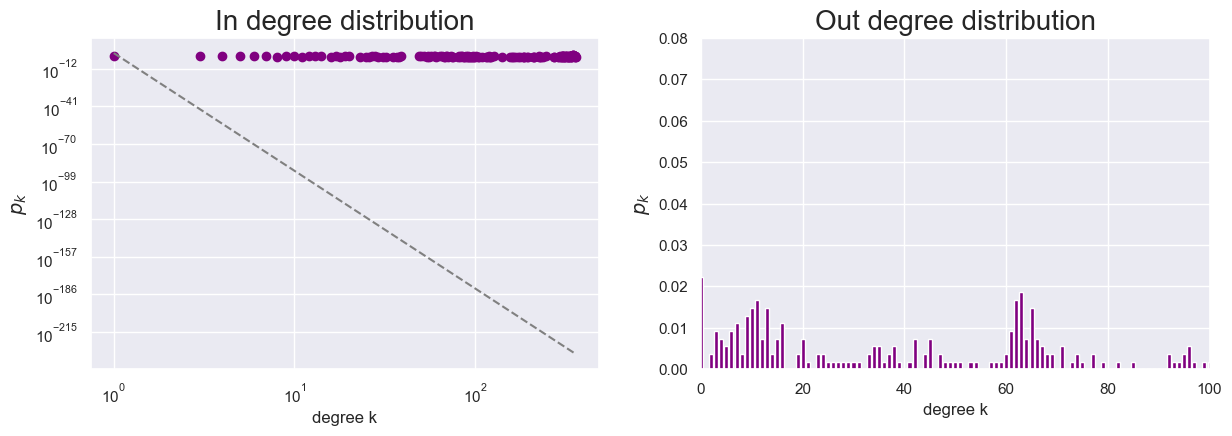

In [30]:
# Binning the degree distribution
bins_in_degrees = np.arange(np.min(in_degrees),np.max(in_degrees),1)
freq_in_degrees, hist_in_degrees = np.histogram(in_degrees, bins = bins_in_degrees);
bins_out_degrees = np.arange(np.min(out_degrees),np.max(out_degrees),1)
freq_out_degrees, hist_out_degrees = np.histogram(out_degrees, bins = bins_out_degrees);

p_k_in = [i/np.sum(freq_in_degrees) for i in freq_in_degrees]
p_k_out = [i/np.sum(freq_out_degrees) for i in freq_out_degrees]


# Plotting
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig.tight_layout()
ax1.set_title('In degree distribution', fontsize = 20)
ax1.set_xlabel('degree k', fontsize = 12)
ax1.set_ylabel("$p_{k}$", fontsize = 14)
#ax1.set_xlim(0,100)
ax1.set_xscale("log");
ax1.set_yscale("log");
#ax1.scatter(*np.unique(in_degrees, return_counts=True), color = 'purple');
#ax1.scatter(hist_in_degrees[:-1], freq_in_degrees, color = 'purple');
ax1.scatter(hist_in_degrees[:-1], p_k_in, color = 'purple');

ax2.set_title('Out degree distribution', fontsize = 20)
ax2.set_xlabel('degree k', fontsize = 12)
ax2.set_ylabel('$p_{k}$', fontsize = 14)
ax2.set_xlim(0,100)
ax2.set_ylim(0,0.08)
#ax2.bar(*np.unique(out_degrees, return_counts=True), color = 'purple');
#ax2.bar(hist_out_degrees[:-1], freq_out_degrees, color = 'purple');
ax2.bar(hist_out_degrees[:-1], p_k_out, color = 'purple');

plt.subplots_adjust(wspace = 0.2)



fit = powerlaw.Fit(in_degrees)
gamma = fit.alpha
print(f'The slope of the in degree distribution when fitted with a power law: {gamma}')
powerlaw_fit = [d**(-gamma) for d in hist_in_degrees[1:]]
ax1.plot(hist_in_degrees[1:], powerlaw_fit, c = 'grey', linestyle='dashed');

#ax1.fit.power_law.plot_pdf()
#fit.plot_pdf( color= 'b')

In [32]:
# marvel_char = [x for x,y in DG.nodes(data=True) if y['Universe']=='Marvel']
# dc_char = [x for x,y in DG.nodes(data=True) if y['Universe']=='DC']

top_in_degrees = sorted(DG.in_degree(), key = operator.itemgetter(1,0), reverse = True)
top_out_degrees = sorted(DG.out_degree(), key = operator.itemgetter(1,0), reverse = True)

print(f'Top 10 in_degree:')
for name, count in top_in_degrees[:10]:
    print(f"{name :<25}: {count}")
    
print(f'\nTop 10 out_degree:')
for name, count in top_out_degrees[:10]:
    print(f"{name:<25}: {count}")


Top 10 in_degree:
Alexandria Ocasio-Cortez : 364
Eric Swalwell            : 361
Eddie Bernice Johnson    : 360
Debbie Wasserman Schultz : 359
David Schweikert         : 359
Barbara Lee              : 358
Henry Cuellar            : 357
Chip Roy                 : 357
Brian Babin              : 357
Adriano Espaillat        : 357

Top 10 out_degree:
Lizzie Fletcher          : 197
John W. Rose             : 195
John Joyce               : 194
Guy Reschenthaler        : 194
Veronica Escobar         : 193
Sylvia R. Garcia         : 193
Earl L. "Buddy" Carter   : 193
Michael Cloud            : 192
A. Drew Ferguson IV      : 192
Salud O. Carbajal        : 191


### Network Plot

In [33]:
#Extract largest component
nodes = max(nx.weakly_connected_components(DG), key=len)
GCC = DG.subgraph(nodes).copy()

# Convert to undirected graph for plotting
UGCC = GCC.to_undirected()

In [35]:
# Assigning node colors and sizes based on universe and degree
node_color = []
for node, attribute in UGCC.nodes(data=True):
    if attribute['Party'] == 'Republican':
        node_color.append('red')
    else:
        node_color.append('Blue')
#print(dict(UGCC.degree).values())

edge_color = []
for n1, n2 in UGCC.edges():
    uni1 = UGCC.nodes[n1]['Party']
    uni2 = UGCC.nodes[n2]['Party']
    if uni1 == 'Republican' and uni2 == 'Republican':
        edge_color.append('orange')
    elif uni1 != uni2:
        edge_color.append('green')
    else:
        edge_color.append('yellow')
        
d = dict(UGCC.degree).values()
scale = 1
node_size = [degree*scale for degree in d]

In [36]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.0,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2,
                        strongGravityMode=False,
                        gravity=1.5,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(UGCC, pos=None, iterations=500);

100%|██████████| 500/500 [00:04<00:00, 104.49it/s]

BarnesHut Approximation  took  0.89  seconds
Repulsion forces  took  3.16  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.49  seconds
AdjustSpeedAndApplyForces step  took  0.10  seconds


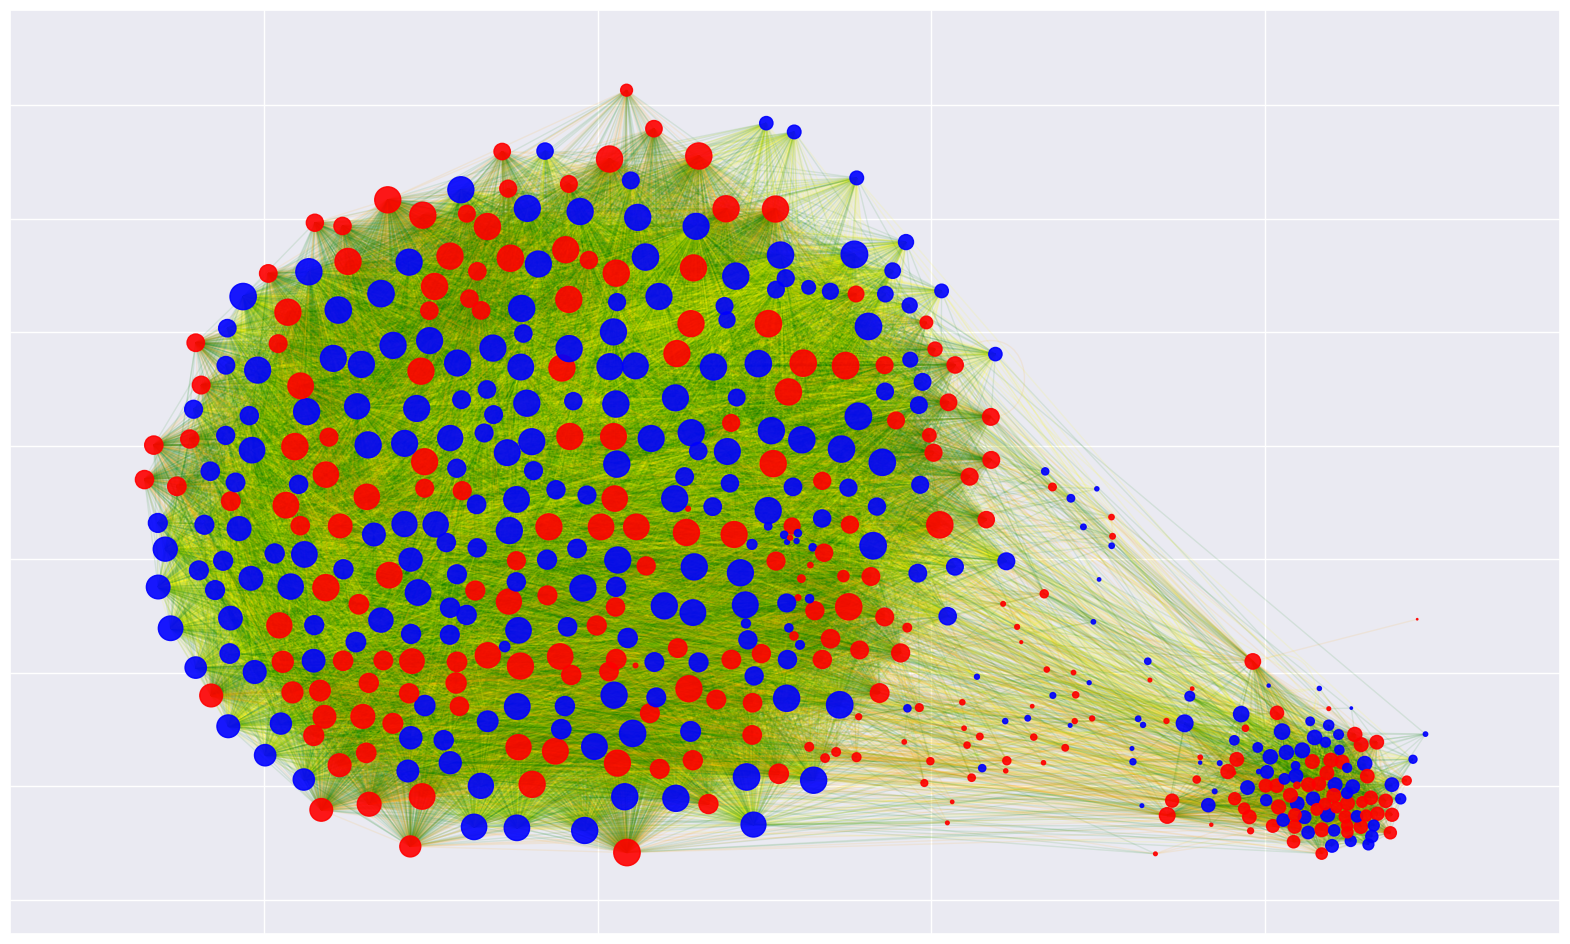

In [37]:
plt.figure(1,figsize=(20,12)) 
nx.draw_networkx_nodes(UGCC, pos = positions, node_size=node_size, node_color=node_color, alpha=0.9);
nx.draw_networkx_edges(UGCC, pos = positions, edge_color=edge_color, alpha=0.1);
plt.show()